Name | Matr.Nr. | Due Date
:--- | ---: | ---:
Mohamed Abdelaziz | 12137202 | 27.05.2022, 08:00

<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 4 &ndash; Recurrent Neural Networks (Assignment)</h2>

<b>Authors:</b> B. Schäfl, S. Lehner, J. Brandstetter, E. Kobler<br>
<b>Date:</b> 27-04-2022

This file is part of the "Hands-on AI II" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this material, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h3 style="color:rgb(0,120,170)">How to use this notebook</h3>
This notebook is designed to run from start to finish. There are different tasks (displayed in <span style="color:rgb(248,138,36)">orange boxes</span>) which require your contribution (in form of code, plain text, ...). Most/All of the supplied functions are imported from the file <code>u4_utils.py</code> which can be seen and treated as a black box. However, for further understanding, you can look at the implementations of the helper functions. In order to run this notebook, the packages which are imported at the beginning of <code>u4_utils.py</code> need to be installed.

In [58]:
# Import pre-defined utilities specific to this notebook.
import u4_utils as u4

# Import additional utilities needed in this notebook.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

# Set default plotting style.
sns.set()

# Setup Jupyter notebook (warning: this may affect all Jupyter notebooks running on the same Jupyter server).
u4.setup_jupyter()

# Check minimum versions.
u4.check_module_versions()

Installed Python version: 3.8 (✓)
Installed numpy version: 1.22.2 (✓)
Installed pandas version: 1.4.1 (✓)
Installed PyTorch version: 1.10.2+cu113 (✓)
Installed matplotlib version: 3.5.1 (✓)
Installed seaborn version: 0.11.2 (✓)


<a name="exercise-latch-sequence-set"></a><h2>The Latch Sequence Data Set</h2>
<p>In the accompanying excercise class, the <i>latch task</i> was presented. You'll be working with the same data set in this assignment. The original latch task was introduced by Hochreiter and Mozer:
<center>
    <cite>Sepp Hochreiter, Michael Mozer, 2001. A discrete probabilistic memory model for discovering dependencies in time. Artificial Neural Networks -- ICANN 2001, 13, pp.661-668.</cite>
</center></p>

<p>The essence of this task is that a sequence of inputs is presented, beginning with one of two symbols, <b>A</b> or <b>B</b>, and after a variable number of time steps, the model has to output a corresponding symbol. Thus, the task requires memorizing the original input over time. It has to be noted that in the <i>original</i> task desription, both class-defining symbols must only appear at the first position of an instance.</p>

<p>The modified version of this task used in this assignment is identical to the one discussed during the accompanying exercise, with the difference of a higher amount of possible targets. Defining arguments are:

<table>
    <tr>
        <th>Argument</th>
        <th>Value (used in this assignment)</th>
        <th>Description</th>
    </tr>
    <tr>
        <th><code>num_samples</code></th>
        <th>4096</th>
        <th>Amount of samples of the full dataset.</th>
    </tr>
    <tr>
        <th><code>num_instances</code></th>
        <th>64</th>
        <th>Amount of instances per sample (sample length).</th>
    </tr>
    <tr>
        <th><code>num_characters</code></th>
        <th>26</th>
        <th>Amount of different characters (size of the one-hot encoded vector).</th>
    </tr>
    <tr>
        <th><code>num_targets</code></th>
        <th>25</th>
        <th>Amount of different characters used as possible targets.</th>
    </tr>
    <tr>
        <th><code>seed</code></th>
        <th>42</th>
        <th>Random seed used to generate the samples of the data set.</th>
    </tr>
</table></p>

<div class="alert alert-warning">
    <b>Exercise 1.1. [8 Points]</b>
    <ul>
        <li>Generate a <i>latch sequence</i> data set with the properties as described in the table <i>above</i>.</li>
        <li>Visualize the last sequence of the data set in <i>tabular</i> form, with all $1$ 
            in <b style="color:blue">bold blue</b> and all $0$ in <span style="font-weight: lighter">lighter</span>.</li>
        <li>Visualize the <i>first</i> $32$ samples in a heatmap, once <i>without</i> and once <i>with</i> a corresponding prefix-mask.</li>
        <li>Interpreting the previous visualizations, which <i>character</i> of the chosen alphabet determines the <i>prefix</i>?</li>
    </ul>
</div>

In [59]:
data_latch = u4.LatchSequenceSet(
    num_samples=4096,
    num_instances=64,
    num_characters=26,
    num_targets=25,
    seed=42)

# Last Sequence Visualization
data_sample = pd.DataFrame(data_latch[-1][0].transpose(0, 1).numpy()).astype(int)
data_sample.style.applymap(lambda _: f'color: {"blue" if _ == 1 else "default"};font-weight: bold')

# DataLoader for All [batch=32]
data_loader = torch.utils.data.DataLoader(dataset=data_latch, batch_size=32)

In [60]:
# Last Sequence Visualization
data_sample = pd.DataFrame(data_latch[-1][0].transpose(0, 1).numpy()).astype(int)
data_sample.style.applymap(lambda _: f'color: {"blue" if _ == 1 else "default"};font-weight: bold')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


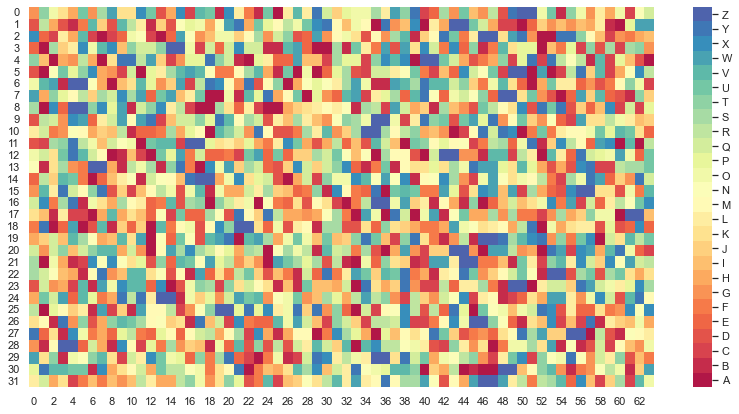

In [61]:
u4.set_seed(42)

data_heatmap = iter(data_loader).next()[0]
data_heatmap = pd.DataFrame(map(lambda _: torch.argmax(_, dim=1).numpy(), data_heatmap))

u4.plot_heatmap(data=data_heatmap, figsize=(14, 7))

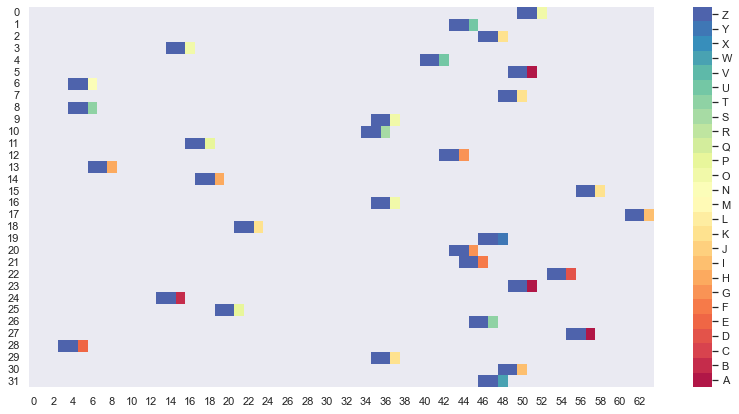

In [62]:
u4.set_seed(42)

data_heatmap = iter(data_loader).next()[0]
data_heatmap = pd.DataFrame(map(lambda _: torch.argmax(_, dim=1).numpy(), data_heatmap))

u4.plot_heatmap(data=data_heatmap, prefix_mask=True, prefix_index=data_latch.num_targets, figsize=(14, 7))

In [63]:
# The Character that determines the prefix is 'Z' character number 26 in the alphabet.

<div class="alert alert-warning">
    <b>Exercise 1.2. [7 Points]</b>
    <ul>
        <li>Linearly split the data set into a <i>training</i> and a <i>test</i> set in a ratio of $3:1$ (use a <code>SubsetRandomSampler</code> and a batch size of $64$).</li>
        <li>Compute and print the <i>amount of samples</i> of each of the respective sets and verify the $3 : 1$ split.</li>
        <li>Visualize the <i>character counts</i> of the <i>first</i> training mini-batch appropriately. What is the count of the <i>prefix</i> character? Provide a formula as a function of the <i>batch_size</i> to compute the count of the <i>prefix</i> character.</li>
    </ul>
</div>

In [64]:
batch_size = 64
test_size = min(max(1, data_latch.num_samples // 4), len(data_latch) - 1)

# Training Set Loader
sampler_train = torch.utils.data.SubsetRandomSampler(list(range(test_size, data_latch.num_samples)))
data_loader_train = torch.utils.data.DataLoader(dataset=data_latch, batch_size=batch_size, sampler=sampler_train)

# Testing Set Loader
sampler_test = torch.utils.data.SubsetRandomSampler(list(range(test_size)))
data_loader_test = torch.utils.data.DataLoader(dataset=data_latch, batch_size=batch_size, sampler=sampler_test)

In [65]:
print(f'Training Set\t\t{len(sampler_train)} samples\n'
      f'Testing Set\t\t{len(sampler_test)} samples\n'
      f'Train:Test ratio\t{len(sampler_train)/len(sampler_test)}')

Training Set		3072 samples
Testing Set		1024 samples
Train:Test ratio	3.0


Character #26: 128
Indiviual Characters: {0: 148, 1: 158, 2: 136, 3: 155, 4: 161, 5: 163, 6: 170, 7: 142, 8: 147, 9: 145, 10: 173, 11: 150, 12: 148, 13: 164, 14: 165, 15: 156, 16: 152, 17: 145, 18: 171, 19: 162, 20: 169, 21: 168, 22: 164, 23: 204, 24: 152, 25: 128}


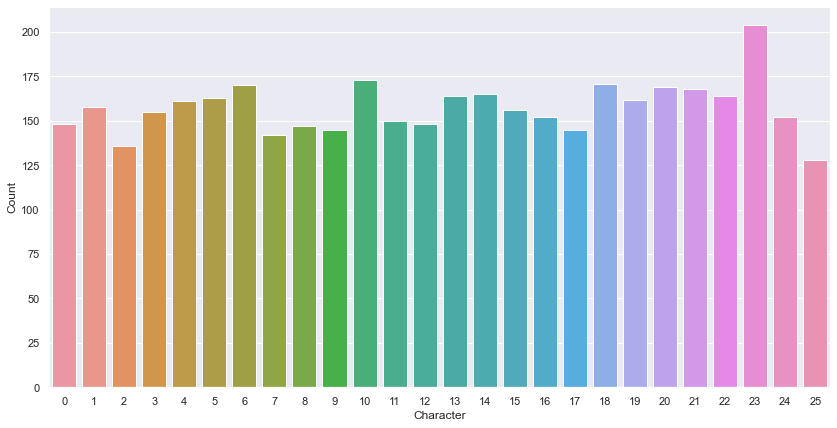

In [66]:
u4.set_seed(42)

data_histogram = iter(data_loader_train).next()[0]
data_histogram = pd.DataFrame(map(lambda _: torch.argmax(_, dim=1).numpy(), data_histogram))
data_histogram = data_histogram.to_numpy().flatten()

fig, ax = plt.subplots(figsize=(14, 7))
count_plot = sns.countplot(x=data_histogram, ax=ax)
_ = count_plot.set(xlabel='Character', ylabel='Count')


unique, counts = np.unique(data_histogram, return_counts=True)
# print(counts[-1])                        # Last Character in this particular case
print(f'Character #26: {counts[25]}')      # Number of characters - 1 (Starting from 0) + 1 To get next character

# Counts of all the characters
print(f'Indiviual Characters: {dict(zip(unique, counts))}')

In [67]:
def prefix_count(batch_size, dataset=data_latch, character=26):
    u4.set_seed(42)
    data_loader = torch.utils.data.DataLoader(dataset=data_latch, batch_size=batch_size)
    data_histogram = iter(data_loader).next()[0]
    data_histogram = pd.DataFrame(map(lambda _: torch.argmax(_, dim=1).numpy(), data_histogram))
    data_histogram = data_histogram.to_numpy().flatten()
    unique, counts = np.unique(data_histogram, return_counts=True)
    return counts[character-1]

prefix_count(64)

128

<a name="exercise-latch-cnn"></a><h2>Tackling Sequence Data with CNNs</h2>
<p>During the accompanying exercise class, a <i>dense feed-forward</i> network was presented as some kind of baseline. Afterwards, recurrent architectures were applied. In this exercise, you'll be tasked with implementing a <i>convolutional</i> architecture for handling sequence data.</p>

<div class="alert alert-warning">
    The following code snippet is taken from the accompanying exercise notebook. You do not need to modify it for this assignment.
</div>

In [68]:
class TheMightyDice(torch.nn.Module):
    """
    Dice roll "network" tailored to deliver random outcomes.
    """
    
    def __init__(self, output_size: int):
        super(TheMightyDice, self).__init__()
        self.__output_size = output_size
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.rand(size=(x.shape[0], self.__output_size), device=x.device)

<div class="alert alert-warning">
    <b>Exercise 2.1. [7 Points]</b>
    <ul>
        <li>Test a <code>TheMightyDice</code> instance on the latch sequence <i>test</i> set. Do you expect this result? Comment on your answer.</li>
        <li>Assume <i>uniformly</i> distributed targets. If a model would <i>always</i> predict the same class, what would the accuracy be?</li>
    </ul>
</div>

In [69]:
# CUDA Version
u4.set_seed(42)

target_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dice = TheMightyDice(output_size=data_latch.num_targets).to(device=target_device)

performance = u4.test_network(model=dice, data_loader=data_loader_test, device=target_device)
print(f'\nFinal loss: {performance[0]:.4f} / Final accuracy: {performance[1]:.4f}')


Final loss: 0.0510 / Final accuracy: 0.0332


In [70]:
# CPU Version
u4.set_seed(42)

target_device = torch.device('cpu')
dice = TheMightyDice(output_size=data_latch.num_targets).to(device=target_device)

performance = u4.test_network(model=dice, data_loader=data_loader_test, device=target_device)
print(f'\nFinal loss: {performance[0]:.4f} / Final accuracy: {performance[1]:.4f}')


Final loss: 0.0510 / Final accuracy: 0.0420


In [71]:
# The Model is behaving as expected since its displaying a random guess out of a pool consisting of 25 targets,
# Assuming the targets are uniformly distrubuted this would give us "1/num_targets" or 1/25 = 0.04  if it's predicting
# only 1 class all the time or even a random choice should yield the same result "with large enough dataset as the lim"

<div class="alert alert-warning">
    <b>Exercise 2.2. [15 Points]</b>
    <ul>
        <li>Implement a function for computing the output size of a convolution operation. Hint: have a look at the <a href="https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html">PyTorch documentation</a>. You may also use <i>your</i> implementation from the <i>first</i> assignment.</li>
        <li>Implement a class <code>CNN</code> with the following architecture:</li>
    </ul>
    <table style="text-align:center;vertical-align:middle">
        <th>Position</th>
        <th>Element</th>
        <th>Comment</th>
        <tr>
            <td>0</td>
            <td>input</td>
            <td>-</td>
        </tr>
        <tr>
            <td>1</td>
            <td>1D convolution</td>
            <td>$256$ output channels and a configurable kernel size (specified as an argument to <code>__init__</code>)</td>
        </tr>
        <tr>
            <td>2</td>
            <td>ReLU</td>
            <td>-</td>
        </tr>
        <tr>
            <td>3</td>
            <td>1D convolution</td>
            <td>$256$ output channels and the same kernel size as the <i>1D convolution</i> at position $1$</td>
        </tr>
        <tr>
            <td>4</td>
            <td>ReLU</td>
            <td>-</td>
        </tr>
        <tr>
            <td>5</td>
            <td>fully connected</td>
            <td><code>num_targets</code> output features (as specified during the data set creation)</td>
        </tr>
        <tr>
            <td>6</td>
            <td>output</td>
            <td>-</td>
        </tr>
    </table>
    <ul>
        <li>Train a <code>CNN</code> network for $15$ epochs, print the training accuracy as well as the loss per epoch and report the final test set loss and accuracy as well as the number of trainable parameters. Use a <i>kernel size</i> of $1$.</li>
        <li>Repeat the same procedure with a second <code>CNN</code> but a <i>kernel size</i> of $3$. Do you observe any differences? Comment and interpret your results.</li>
    </ul>
</div>

In [72]:
class CNN(torch.nn.Module):
    def __init__(self, kernel_size=3):
        super().__init__()
        self.conv1 = torch.nn.Conv1d(data_latch.num_characters, 256, kernel_size=kernel_size)
        self.relu1 = torch.nn.ReLU()
        self.seq_len = self.get_seq_len(l_i=data_latch.num_instances, kernel=kernel_size)
        
        self.conv2 = torch.nn.Conv1d(256, 256, kernel_size=kernel_size)
        self.relu2= torch.nn.ReLU()
        self.seq_len = self.get_seq_len(l_i=self.seq_len, kernel=kernel_size)

        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(256*self.seq_len, data_latch.num_targets)
        
    def forward(self, x):
        x = self.conv1(x.transpose(1,-1))
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        
        x = self.flatten(x)
        x = self.fc1(x)

        return x
    
    def get_seq_len(self, l_i=data_latch.num_instances, kernel=3, padding=0, dilation=1, stride=1):
        return int(((l_i + 2 * padding - dilation * (kernel-1) - 1) / stride) + 1)

In [73]:
# CUDA Version!!
# kernel_size = 1
u4.set_seed(42)

# Create CNN instance and the corresponding optimizer to use.
target_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_1 = CNN(kernel_size=1).to(target_device)
print(cnn_1)
optimizer = torch.optim.SGD(cnn_1.parameters(), lr=1e-3)

num_epochs = 15
for epoch in range(num_epochs):
    u4.train_network(model=cnn_1, data_loader=data_loader_train, device=target_device, optimizer=optimizer)
    
    performance = u4.test_network(model=cnn_1, data_loader=data_loader_train, device=target_device)
    
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Train loss: {performance[0]:.4f} / Train accuracy: {performance[1]:.4f}')

performance = u4.test_network(model=cnn_1, data_loader=data_loader_test, device=target_device)
print(f'\nTest loss: {performance[0]:.4f} / Test accuracy: {performance[1]:.4f}')

CNN(
  (conv1): Conv1d(26, 256, kernel_size=(1,), stride=(1,))
  (relu1): ReLU()
  (conv2): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
  (relu2): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=16384, out_features=25, bias=True)
)
Epoch: 01 / Train loss: 0.0503 / Train accuracy: 0.0413
Epoch: 02 / Train loss: 0.0503 / Train accuracy: 0.0465
Epoch: 03 / Train loss: 0.0503 / Train accuracy: 0.0475
Epoch: 04 / Train loss: 0.0503 / Train accuracy: 0.0498
Epoch: 05 / Train loss: 0.0503 / Train accuracy: 0.0508
Epoch: 06 / Train loss: 0.0503 / Train accuracy: 0.0518
Epoch: 07 / Train loss: 0.0503 / Train accuracy: 0.0518
Epoch: 08 / Train loss: 0.0502 / Train accuracy: 0.0547
Epoch: 09 / Train loss: 0.0502 / Train accuracy: 0.0537
Epoch: 10 / Train loss: 0.0502 / Train accuracy: 0.0518
Epoch: 11 / Train loss: 0.0502 / Train accuracy: 0.0508
Epoch: 12 / Train loss: 0.0502 / Train accuracy: 0.0488
Epoch: 13 / Train loss: 0.0502 / Train accuracy: 0.0482
Epo

In [74]:
# CPU Version!!
# kernel_size = 1
u4.set_seed(42)

target_device = torch.device('cpu')
cnn_1_cpu = CNN(kernel_size=1).to(target_device)
print(cnn_1_cpu)
optimizer = torch.optim.SGD(cnn_1_cpu.parameters(), lr=1e-3)

num_epochs = 15
for epoch in range(num_epochs):
    u4.train_network(model=cnn_1_cpu, data_loader=data_loader_train, device=target_device, optimizer=optimizer)
    
    performance = u4.test_network(model=cnn_1_cpu, data_loader=data_loader_train, device=target_device)
    
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Train loss: {performance[0]:.4f} / Train accuracy: {performance[1]:.4f}')

performance = u4.test_network(model=cnn_1_cpu, data_loader=data_loader_test, device=target_device)
print(f'\nTest loss: {performance[0]:.4f} / Test accuracy: {performance[1]:.4f}')

CNN(
  (conv1): Conv1d(26, 256, kernel_size=(1,), stride=(1,))
  (relu1): ReLU()
  (conv2): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
  (relu2): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=16384, out_features=25, bias=True)
)
Epoch: 01 / Train loss: 0.0503 / Train accuracy: 0.0413
Epoch: 02 / Train loss: 0.0503 / Train accuracy: 0.0465
Epoch: 03 / Train loss: 0.0503 / Train accuracy: 0.0475
Epoch: 04 / Train loss: 0.0503 / Train accuracy: 0.0498
Epoch: 05 / Train loss: 0.0503 / Train accuracy: 0.0508
Epoch: 06 / Train loss: 0.0503 / Train accuracy: 0.0518
Epoch: 07 / Train loss: 0.0503 / Train accuracy: 0.0518
Epoch: 08 / Train loss: 0.0502 / Train accuracy: 0.0547
Epoch: 09 / Train loss: 0.0502 / Train accuracy: 0.0537
Epoch: 10 / Train loss: 0.0502 / Train accuracy: 0.0518
Epoch: 11 / Train loss: 0.0502 / Train accuracy: 0.0508
Epoch: 12 / Train loss: 0.0502 / Train accuracy: 0.0488
Epoch: 13 / Train loss: 0.0502 / Train accuracy: 0.0482
Epo

In [83]:
# CUDA Version!!
# kernel_size = 3
u4.set_seed(42)

target_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_3 = CNN(kernel_size=3).to(target_device)
print(cnn_3)
optimizer = torch.optim.SGD(cnn_3.parameters(), lr=1e-2)

num_epochs = 15
for epoch in range(num_epochs):
    u4.train_network(model=cnn_3, data_loader=data_loader_train, device=target_device, optimizer=optimizer)
    
    performance = u4.test_network(model=cnn_3, data_loader=data_loader_train, device=target_device)
    
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Train loss: {performance[0]:.4f} / Train accuracy: {performance[1]:.4f}')

performance = u4.test_network(model=cnn_3, data_loader=data_loader_test, device=target_device)

print(f'\nTest loss: {performance[0]:.4f} / Test accuracy: {performance[1]:.4f}')

CNN(
  (conv1): Conv1d(26, 256, kernel_size=(3,), stride=(1,))
  (relu1): ReLU()
  (conv2): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
  (relu2): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=15360, out_features=25, bias=True)
)
Epoch: 01 / Train loss: 0.0503 / Train accuracy: 0.0479
Epoch: 02 / Train loss: 0.0502 / Train accuracy: 0.0540
Epoch: 03 / Train loss: 0.0502 / Train accuracy: 0.0553
Epoch: 04 / Train loss: 0.0502 / Train accuracy: 0.0537
Epoch: 05 / Train loss: 0.0501 / Train accuracy: 0.0524
Epoch: 06 / Train loss: 0.0501 / Train accuracy: 0.0563
Epoch: 07 / Train loss: 0.0501 / Train accuracy: 0.0508
Epoch: 08 / Train loss: 0.0501 / Train accuracy: 0.0488
Epoch: 09 / Train loss: 0.0500 / Train accuracy: 0.0492
Epoch: 10 / Train loss: 0.0500 / Train accuracy: 0.0501
Epoch: 11 / Train loss: 0.0500 / Train accuracy: 0.0501
Epoch: 12 / Train loss: 0.0499 / Train accuracy: 0.0534
Epoch: 13 / Train loss: 0.0499 / Train accuracy: 0.0557
Epo

In [76]:
# CPU Version!!
# kernel_size = 3
u4.set_seed(42)

target_device = torch.device('cpu')
cnn_3_cpu = CNN(kernel_size=3).to(target_device)
print(cnn_3_cpu)
optimizer = torch.optim.SGD(cnn_3.parameters(), lr=1e-3)

num_epochs = 15
for epoch in range(num_epochs):
    u4.train_network(model=cnn_3_cpu, data_loader=data_loader_train, device=target_device, optimizer=optimizer)
    
    performance = u4.test_network(model=cnn_3_cpu, data_loader=data_loader_train, device=target_device)
    
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Train loss: {performance[0]:.4f} / Train accuracy: {performance[1]:.4f}')

performance = u4.test_network(model=cnn_3_cpu, data_loader=data_loader_test, device=target_device)

print(f'\nTest loss: {performance[0]:.4f} / Test accuracy: {performance[1]:.4f}')

CNN(
  (conv1): Conv1d(26, 256, kernel_size=(3,), stride=(1,))
  (relu1): ReLU()
  (conv2): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
  (relu2): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=15360, out_features=25, bias=True)
)
Epoch: 01 / Train loss: 0.0503 / Train accuracy: 0.0420
Epoch: 02 / Train loss: 0.0503 / Train accuracy: 0.0420
Epoch: 03 / Train loss: 0.0503 / Train accuracy: 0.0420
Epoch: 04 / Train loss: 0.0503 / Train accuracy: 0.0420
Epoch: 05 / Train loss: 0.0503 / Train accuracy: 0.0420
Epoch: 06 / Train loss: 0.0503 / Train accuracy: 0.0420
Epoch: 07 / Train loss: 0.0503 / Train accuracy: 0.0420
Epoch: 08 / Train loss: 0.0503 / Train accuracy: 0.0420
Epoch: 09 / Train loss: 0.0503 / Train accuracy: 0.0420
Epoch: 10 / Train loss: 0.0503 / Train accuracy: 0.0420
Epoch: 11 / Train loss: 0.0503 / Train accuracy: 0.0420
Epoch: 12 / Train loss: 0.0503 / Train accuracy: 0.0420
Epoch: 13 / Train loss: 0.0503 / Train accuracy: 0.0420
Epo

In [77]:
# Both models doesn't seem to learn anything, which is reflected on the test accuracy that represents a random guess "1/25"
# Although the kernel-3 [CUDA Version!!] Network seems to have been very slowly learning[Assuming the CUDA Version],
# it was just overfitting the data; While in cpu version we get that it's only predicting one class only probably "Zeros"
# since it's numerically unstable.

<div class="alert alert-warning">
    <b>Exercise 2.3. [12 Points]</b>
    <ul>
        <li>Implement a class <code>PoolCNN</code> with the following architecture:</li>
    </ul>
    <table style="text-align:center;vertical-align:middle">
        <th>Position</th>
        <th>Element</th>
        <th>Comment</th>
        <tr>
            <td>0</td>
            <td>input</td>
            <td>-</td>
        </tr>
        <tr>
            <td>1</td>
            <td>1D convolution</td>
            <td>$32$ output channels and a kernel size of $3$</td>
        </tr>
        <tr>
            <td>2</td>
            <td>ReLU</td>
            <td>-</td>
        </tr>
        <tr>
            <td>3</td>
            <td>1d adaptive max pool</td>
            <td>$1$ output size (<a href="https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveMaxPool1d.html">PyTorch documentation</a>)</td>
        </tr>
        <tr>
            <td>4</td>
            <td>fully connected</td>
            <td><code>num_targets</code> output features (as specified during the data set creation)</td>
        </tr>
        <tr>
            <td>5</td>
            <td>output</td>
            <td>-</td>
        </tr>
    </table>
    <ul>
        <li>Train a <code>PoolCNN</code> network for $15$ epochs, print the training accuracy as well as the loss per epoch and report the final test set loss and accuracy as well as the number of trainable parameters.
        <li>Compare the results of the <code>PoolCNN</code> network with those of the <code>CNN</code> network. What do you observe? Interpret and discuss your results.</li>
    </ul>
</div>

In [86]:
class PoolCNN(torch.nn.Module):
    def __init__(self, kernel_size=3):
        super().__init__()
        self.conv1 = torch.nn.Conv1d(data_latch.num_characters, 32, kernel_size=kernel_size)
        self.relu1 = torch.nn.ReLU()
        self.amp = torch.nn.AdaptiveMaxPool1d(1)
        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(32, data_latch.num_targets)
        
    def forward(self, x):
        x = self.conv1(x.transpose(1,-1))
        x = self.relu1(x)
        x = self.amp(x)
        x = self.flatten(x)
        x = self.fc1(x)

        return x

In [87]:
# CUDA Version!!
u4.set_seed(42)

target_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pool_cnn = PoolCNN().to(target_device)
optimizer = torch.optim.SGD(pool_cnn.parameters(), lr=1e-3)

num_epochs = 15
for epoch in range(num_epochs):
    u4.train_network(model=pool_cnn, data_loader=data_loader_train, device=target_device, optimizer=optimizer)
    
    # Evaluate current CNN instance.
    performance = u4.test_network(model=pool_cnn, data_loader=data_loader_train, device=target_device)
    
    # Print result of current epoch to standard out.
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Train loss: {performance[0]:.4f} / Train accuracy: {performance[1]:.4f}')

# Evaluate final model on test data set.
performance = u4.test_network(model=pool_cnn, data_loader=data_loader_test, device=target_device)

print(f'\nTest loss: {performance[0]:.4f} / Test accuracy: {performance[1]:.4f}')

Epoch: 01 / Train loss: 0.0505 / Train accuracy: 0.0400
Epoch: 02 / Train loss: 0.0505 / Train accuracy: 0.0400
Epoch: 03 / Train loss: 0.0505 / Train accuracy: 0.0400
Epoch: 04 / Train loss: 0.0505 / Train accuracy: 0.0400
Epoch: 05 / Train loss: 0.0505 / Train accuracy: 0.0400
Epoch: 06 / Train loss: 0.0505 / Train accuracy: 0.0400
Epoch: 07 / Train loss: 0.0505 / Train accuracy: 0.0400
Epoch: 08 / Train loss: 0.0505 / Train accuracy: 0.0400
Epoch: 09 / Train loss: 0.0505 / Train accuracy: 0.0400
Epoch: 10 / Train loss: 0.0505 / Train accuracy: 0.0400
Epoch: 11 / Train loss: 0.0505 / Train accuracy: 0.0400
Epoch: 12 / Train loss: 0.0505 / Train accuracy: 0.0400
Epoch: 13 / Train loss: 0.0505 / Train accuracy: 0.0400
Epoch: 14 / Train loss: 0.0505 / Train accuracy: 0.0400
Epoch: 15 / Train loss: 0.0505 / Train accuracy: 0.0400

Test loss: 0.0505 / Test accuracy: 0.0371


In [88]:
# CPU Version!!
u4.set_seed(42)

target_device = torch.device('cpu')
pool_cnn_cpu = PoolCNN().to(target_device)
optimizer = torch.optim.SGD(pool_cnn_cpu.parameters(), lr=1e-3)

num_epochs = 15
for epoch in range(num_epochs):
    u4.train_network(model=pool_cnn_cpu, data_loader=data_loader_train, device=target_device, optimizer=optimizer)
    
    # Evaluate current CNN instance.
    performance = u4.test_network(model=pool_cnn_cpu, data_loader=data_loader_train, device=target_device)
    
    # Print result of current epoch to standard out.
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Train loss: {performance[0]:.4f} / Train accuracy: {performance[1]:.4f}')

# Evaluate final model on test data set.
performance = u4.test_network(model=pool_cnn_cpu, data_loader=data_loader_test, device=target_device)

print(f'\nTest loss: {performance[0]:.4f} / Test accuracy: {performance[1]:.4f}')

Epoch: 01 / Train loss: 0.0505 / Train accuracy: 0.0400
Epoch: 02 / Train loss: 0.0505 / Train accuracy: 0.0400
Epoch: 03 / Train loss: 0.0505 / Train accuracy: 0.0400
Epoch: 04 / Train loss: 0.0505 / Train accuracy: 0.0400
Epoch: 05 / Train loss: 0.0505 / Train accuracy: 0.0400
Epoch: 06 / Train loss: 0.0505 / Train accuracy: 0.0400
Epoch: 07 / Train loss: 0.0505 / Train accuracy: 0.0400
Epoch: 08 / Train loss: 0.0505 / Train accuracy: 0.0400
Epoch: 09 / Train loss: 0.0505 / Train accuracy: 0.0400
Epoch: 10 / Train loss: 0.0505 / Train accuracy: 0.0400
Epoch: 11 / Train loss: 0.0505 / Train accuracy: 0.0400
Epoch: 12 / Train loss: 0.0505 / Train accuracy: 0.0400
Epoch: 13 / Train loss: 0.0505 / Train accuracy: 0.0400
Epoch: 14 / Train loss: 0.0505 / Train accuracy: 0.0400
Epoch: 15 / Train loss: 0.0505 / Train accuracy: 0.0400

Test loss: 0.0505 / Test accuracy: 0.0371


In [81]:
class PoolCNN2(torch.nn.Module):
    def __init__(self, kernel_size=3):
        super().__init__()
        self.conv1 = torch.nn.Conv1d(data_latch.num_characters, 256, kernel_size=kernel_size)
        self.relu1 = torch.nn.ReLU()
        self.amp1 = torch.nn.AdaptiveMaxPool1d(26)
        
        self.conv2 = torch.nn.Conv1d(data_latch.num_characters, 256, kernel_size=kernel_size)
        self.relu2 = torch.nn.ReLU()
        self.amp2 = torch.nn.AdaptiveMaxPool1d(1)
        
        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(256, data_latch.num_targets)
        
    def forward(self, x):
        x = self.conv1(x.transpose(1,-1))
        x = self.relu1(x)
        x = self.amp1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.amp2(x)
        
        x = self.flatten(x)
        x = self.fc1(x)

        return x

In [29]:
# CUDA Version!! [256 Channels instead of 32]
u4.set_seed(42)

target_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pool_cnn2 = PoolCNN2().to(target_device)
optimizer = torch.optim.SGD(pool_cnn2.parameters(), lr=1e-3)

num_epochs = 15
for epoch in range(num_epochs):
    u4.train_network(model=pool_cnn2, data_loader=data_loader_train, device=target_device, optimizer=optimizer)
    
    performance = u4.test_network(model=pool_cnn2, data_loader=data_loader_train, device=target_device)
    
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Train loss: {performance[0]:.4f} / Train accuracy: {performance[1]:.4f}')

performance = u4.test_network(model=pool_cnn2, data_loader=data_loader_test, device=target_device)
print(f'\nTest loss: {performance[0]:.4f} / Test accuracy: {performance[1]:.4f}')

Epoch: 01 / Train loss: 0.0504 / Train accuracy: 0.0342
Epoch: 02 / Train loss: 0.0504 / Train accuracy: 0.0342
Epoch: 03 / Train loss: 0.0504 / Train accuracy: 0.0332
Epoch: 04 / Train loss: 0.0504 / Train accuracy: 0.0352
Epoch: 05 / Train loss: 0.0504 / Train accuracy: 0.0374
Epoch: 06 / Train loss: 0.0504 / Train accuracy: 0.0378
Epoch: 07 / Train loss: 0.0504 / Train accuracy: 0.0407
Epoch: 08 / Train loss: 0.0504 / Train accuracy: 0.0417
Epoch: 09 / Train loss: 0.0504 / Train accuracy: 0.0420
Epoch: 10 / Train loss: 0.0503 / Train accuracy: 0.0433
Epoch: 11 / Train loss: 0.0503 / Train accuracy: 0.0449
Epoch: 12 / Train loss: 0.0503 / Train accuracy: 0.0423
Epoch: 13 / Train loss: 0.0503 / Train accuracy: 0.0426
Epoch: 14 / Train loss: 0.0503 / Train accuracy: 0.0420
Epoch: 15 / Train loss: 0.0503 / Train accuracy: 0.0423

Test loss: 0.0503 / Test accuracy: 0.0410


In [30]:
# The Pool Network stops learning completely due to not only shrinking its size, but because also because of the use of adaptive
# max-pooling since its choosing the maximum value in the 3x3 kernel which "could" mean that its always predicting the same
# class
# While in the Normal CNNs the network seemed to learn something out of the data which was always wrong, thus resulted in overfitting
# in some cases.

In [31]:
# We Can See this behavior because the CNN Models are designed to capture the spatial patterns within the data while in our case
# it is mostly concerned with temporal data (time of occurance) while some researchers argue that this can be remedied by
# converting this temporal represntation in the data into spatial representation first by using "Wavelet Tranformation or
# Fourrier Transformation" during the preprocessing that can extract "some" features in the data beforehand.

<div class="alert alert-warning">
    The following code snippet is taken from the accompanying exercise notebook. You do not need to modify it for this assignment.
</div>

In [32]:
def collect_gradients(model: torch.nn.Module, loader: torch.utils.data.DataLoader) -> pd.DataFrame:
    """
    Auxiliary function for collecting gradient magnitudes of a corresponding model w.r.t. the network input.
    
    :param model: model instance to be used for collecting gradients
    :param device: device to use for gradient collection
    :param loader: data loader supplying the samples used for collecting gradients
    :return: data frame comprising the gradient magnitudes of the loss function w.r.t. each input element
    """
    model_state = model.training
    model.train()
    model.zero_grad()

    # Iterating over the data set and computing the corresponding gradients.
    device, gradients = next(model.parameters())[0].device, []
    criterion = torch.nn.CrossEntropyLoss()
    for batch_index, (data, target) in enumerate(loader):
        data, target = data.float().to(device), target.long().to(device)
        
        # Prepare network input for gradient recording.
        data.requires_grad_(True)
        data.register_hook(lambda _: gradients.append(_.cpu().abs()))

        # One forward
        model.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        model.zero_grad()
    
    # Reset model state and return collected gradients.
    model.train(mode=model_state)
    return pd.DataFrame(torch.cat(gradients, dim=0).mean(dim=2).numpy())

<div class="alert alert-warning">
    <b>Exercise 2.4. [8 Points]</b>
    <ul>
        <li>Create a <i>fresh</i> instance of <code>CNN</code> using a <i>kernel size</i> of $3$ and collect its gradients w.r.t. the network input using the latch sequence training set.</li>
        <li>Visualize the collected gradients accordingly. What do you observe? Comment on your results.</li>
    </ul>
</div>

In [33]:
cnn_3 = CNN(kernel_size=3)
cnn_grads = collect_gradients(model=cnn_3, loader=data_loader_train)

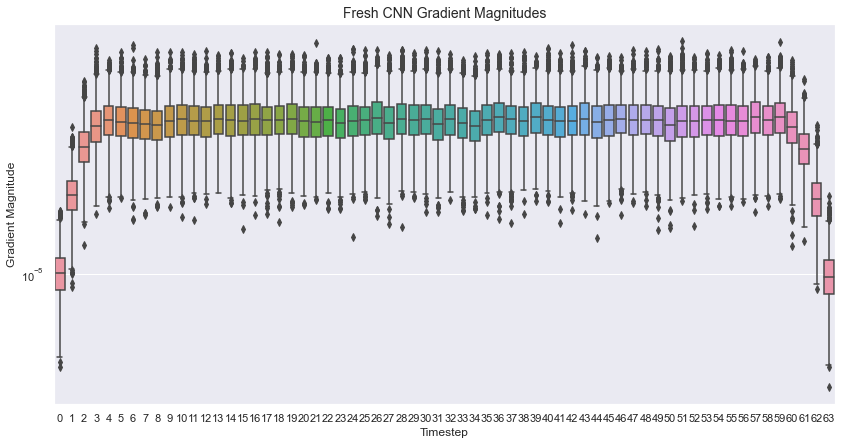

In [34]:
gradients_prepared = pd.melt(cnn_grads, value_vars=cnn_grads.columns)
gradients_prepared.columns = ('Timestep', 'Gradient Magnitude')

fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title('Fresh CNN Gradient Magnitudes', fontsize=14)
ax.set(yscale='log')

_ = sns.boxplot(x='Timestep', y='Gradient Magnitude', data=gradients_prepared, ax=ax)

In [35]:
# We can see a very stable gradient ranges in the middle of the sequence, while lower gradients "comparatively" in the beginning
# and the end of the sequence, which is fairly expected from a fresh cnn.

<a name="exercise-latch-lstm"></a><h2>Tackling Sequence Data with LSTMs</h2>
<p>During the accompanying exercise class, the <i>Long Short-Term Memory (LSTM)</i> was presented as a quite prominent and often used architecture in the recurrent case. It was designed and published by <a href="https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.676.4320&rep=rep1&type=pdf">Hochreiter and Schmidhuber</a>:
    <center>
        <cite>
            Hochreiter, S. and Schmidhuber, J., 1997. Long short-term memory. Neural computation, 9(8), pp.1735-1780.
        </cite>
    </center></p>

<p>It has to be noted, that the most crucial part of the LSTM, the <i>constant error carousel (CEC)</i>, was already discussed during <a href="https://people.idsia.ch//~juergen/SeppHochreiter1991ThesisAdvisorSchmidhuber.pdf">Hochreiter's diploma thesis</a> (in German):
    <center>
            <cite>
                Hochreiter, S., 1991. Untersuchungen zu dynamischen neuronalen Netzen. Diploma, Technische Universität München, 91(1).
            </cite>
    </center></p>

<p>In contrast to most other recurrent architectures like the Elman RNN, the <i>LSTM</i> is a bit more complex, but equally more powerful:
    <center>
        \begin{equation}
            \begin{split}
                i_{t} &= \sigma{\left(W_{ii}x_{t} + b_{ii} + W_{hi}h_{t-1} + b_{hi}\right)} \\
                \color{red}{f_{t}} &\color{red}{= \sigma{\left(W_{if}x_{t} + b_{if} + W_{hf}h_{t-1} + b_{hf}\right)}} \\
                g_{t} &= \tanh{\left(W_{ig}x_{t} + b_{ig} + W_{hg}h_{t-1} + b_{hg}\right)} \\
                o_{t} &= \sigma{\left(W_{io}x_{t} + b_{io} + W_{ho}h_{t-1} + b_{ho}\right)} \\
                c_{t} &= \color{red}{f_{t}\odot{}}c_{t-1} + i_{t}\odot{}g_{t} \\
                h_{t} &= o_{t}\odot{}\tanh{\left(c_{t}\right)}
            \end{split}
        \end{equation}
    </center></p>

<p>We are using the implementation provided by PyTorch, more information may be found in the <a href="https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html?highlight=lstm#torch.nn.LSTM">official documentation</a>. It has to be noted, the the <i>original</i> formulation did <i>not</i> contain an additional <i>forget gate</i> $f_{t}$ (see equations above), as this completely destroys the <i>constant error carousel</i> – it was introduced by <a href="https://www.mitpressjournals.org/doi/pdfplus/10.1162/089976600300015015">Gers et al.</a>:
<center>
    <cite>Gers, F.A., Schmidhuber, J. and Cummins, F., 1999. Learning to forget: Continual prediction with LSTM.
    </cite>
</center></p>
<p>Nonetheless, for <i>some</i> tasks, the forget gate seems to provide a useful addition. Hence, in this exercise you'll be tasked with activating the <i>forget gate</i> and interpreting the results.</p>

<div class="alert alert-warning">
    <b>Exercise 3.1. [13 Points]</b>
    <ul>
        <li>Implement a class <code>LSTM</code> with the following architecture:</li>
    </ul>
    <table style="text-align:center;vertical-align:middle">
        <th>Position</th>
        <th>Element</th>
        <th>Comment</th>
        <tr>
            <td>0</td>
            <td>input</td>
            <td>-</td>
        </tr>
        <tr>
            <td>1</td>
            <td>LSTM</td>
            <td>$32$ memory cells and a configurable initial forget gate bias (specified as an argument to <code>__init__</code>)</td>
        </tr>
        <tr>
            <td>2</td>
            <td>fully connected</td>
            <td><code>num_targets</code> output features (as specified during the data set creation)</td>
        </tr>
        <tr>
            <td>3</td>
            <td>output</td>
            <td>-</td>
        </tr>
    </table>
    <ul>
        <li>Train an <code>LSTM</code> network for $15$ epochs, print the training accuracy as well as the loss per epoch and report the final test set loss and accuracy as well as the number of trainable parameters. Use an initial forget gate bias of $0.0$. Do you expect the resulting performance?</li>
    </ul>
</div>

In [56]:
class LSTM(torch.nn.Module):
    """
    LSTM tailored to process latch sequence data.
    """
    
    def __init__(self, input_size, hidden_size=32, output_size=data_latch.num_targets, forget_gate=False):
        super(LSTM, self).__init__()
        self.lstm1 = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = torch.nn.Linear(self.lstm1.hidden_size, output_size)
        
        if not forget_gate:
            def _reset_forget_gate_hook(_gradients: torch.Tensor) -> torch.Tensor:
                _gradients[_gradients.shape[0] // 4:_gradients.shape[0] // 2].fill_(0.0)
                return _gradients
            
            for name, parameter in self.lstm1.named_parameters():
                if 'bias' in name:
                    parameter.data[(parameter.shape[0] // 4):(parameter.shape[0] // 2)].fill_(1e6)
                    parameter.register_hook(_reset_forget_gate_hook)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.lstm1(x)[0][:, -1, :]
        return self.fc1(x)

In [57]:
# CUDA Version!! Similar to CPU!!
# hidden_size = 32, forget_gate = False
u4.set_seed(42)

target_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model_nf = LSTM(input_size=data_latch.num_characters, output_size=data_latch.num_targets, forget_gate=False).to(target_device)
optimizer = torch.optim.Adam(lstm_model_nf.parameters(), lr=1e-2)

print(lstm_model_nf, end='\n\n')

num_epochs = 15
for epoch in range(num_epochs):
    
    u4.train_network(model=lstm_model_nf, data_loader=data_loader_train, device=target_device, optimizer=optimizer)
    
    performance = u4.test_network(model=lstm_model_nf, data_loader=data_loader_train, device=target_device)
    
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Loss: {performance[0]:.4f} / Accuracy: {performance[1]:.4f}')

performance = u4.test_network(model=lstm_model_nf, data_loader=data_loader_test, device=target_device)
print(f'\nFinal loss: {performance[0]:.4f} / Final accuracy: {performance[1]:.4f}')

LSTM(
  (lstm1): LSTM(26, 32, batch_first=True)
  (fc1): Linear(in_features=32, out_features=25, bias=True)
)

Epoch: 01 / Loss: 0.0503 / Accuracy: 0.0465
Epoch: 02 / Loss: 0.0503 / Accuracy: 0.0423
Epoch: 03 / Loss: 0.0501 / Accuracy: 0.0514
Epoch: 04 / Loss: 0.0501 / Accuracy: 0.0573
Epoch: 05 / Loss: 0.0500 / Accuracy: 0.0615
Epoch: 06 / Loss: 0.0499 / Accuracy: 0.0635
Epoch: 07 / Loss: 0.0498 / Accuracy: 0.0703
Epoch: 08 / Loss: 0.0496 / Accuracy: 0.0674
Epoch: 09 / Loss: 0.0495 / Accuracy: 0.0778
Epoch: 10 / Loss: 0.0493 / Accuracy: 0.0785
Epoch: 11 / Loss: 0.0491 / Accuracy: 0.0827
Epoch: 12 / Loss: 0.0490 / Accuracy: 0.0765
Epoch: 13 / Loss: 0.0488 / Accuracy: 0.0846
Epoch: 14 / Loss: 0.0487 / Accuracy: 0.0866
Epoch: 15 / Loss: 0.0486 / Accuracy: 0.0898

Final loss: 0.0512 / Final accuracy: 0.0518


In [38]:
# CUDA Version!!
# hidden_size = 64, forget_gate = False
u4.set_seed(42)

target_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model_2 = LSTM(input_size=data_latch.num_characters, output_size=data_latch.num_targets, hidden_size=64, forget_gate=False).to(target_device)
optimizer = torch.optim.Adam(lstm_model_2.parameters(), lr=1e-2)

print(lstm_model_2, end='\n\n')

num_epochs = 15
for epoch in range(num_epochs):
    
    u4.train_network(model=lstm_model_2, data_loader=data_loader_train, device=target_device, optimizer=optimizer)
    
    performance = u4.test_network(model=lstm_model_2, data_loader=data_loader_train, device=target_device)
    
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Loss: {performance[0]:.4f} / Accuracy: {performance[1]:.4f}')

performance = u4.test_network(model=lstm_model_2, data_loader=data_loader_test, device=target_device)
print(f'\nFinal loss: {performance[0]:.4f} / Final accuracy: {performance[1]:.4f}')

LSTM(
  (lstm1): LSTM(26, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
)

Epoch: 01 / Loss: 0.0501 / Accuracy: 0.0719
Epoch: 02 / Loss: 0.0495 / Accuracy: 0.0801
Epoch: 03 / Loss: 0.0487 / Accuracy: 0.0951
Epoch: 04 / Loss: 0.0475 / Accuracy: 0.1130
Epoch: 05 / Loss: 0.0479 / Accuracy: 0.1064
Epoch: 06 / Loss: 0.0464 / Accuracy: 0.1393
Epoch: 07 / Loss: 0.0380 / Accuracy: 0.2142
Epoch: 08 / Loss: 0.0190 / Accuracy: 0.6608
Epoch: 09 / Loss: 0.0081 / Accuracy: 0.8480
Epoch: 10 / Loss: 0.0016 / Accuracy: 0.9788
Epoch: 11 / Loss: 0.0002 / Accuracy: 1.0000
Epoch: 12 / Loss: 0.0001 / Accuracy: 1.0000
Epoch: 13 / Loss: 0.0001 / Accuracy: 1.0000
Epoch: 14 / Loss: 0.0001 / Accuracy: 1.0000
Epoch: 15 / Loss: 0.0001 / Accuracy: 1.0000

Final loss: 0.0001 / Final accuracy: 1.0000


In [39]:
# CUDA Version!!
# hidden_size = 128, forget_gate = False
u4.set_seed(42)

target_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model_3 = LSTM(input_size=data_latch.num_characters, output_size=data_latch.num_targets, hidden_size=128, forget_gate=False).to(target_device)
optimizer = torch.optim.Adam(lstm_model_3.parameters(), lr=1e-2)

print(lstm_model_3, end='\n\n')

num_epochs = 15
for epoch in range(num_epochs):
    
    u4.train_network(model=lstm_model_3, data_loader=data_loader_train, device=target_device, optimizer=optimizer)
    
    performance = u4.test_network(model=lstm_model_3, data_loader=data_loader_train, device=target_device)
    
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Loss: {performance[0]:.4f} / Accuracy: {performance[1]:.4f}')

performance = u4.test_network(model=lstm_model_3, data_loader=data_loader_test, device=target_device)
print(f'\nFinal loss: {performance[0]:.4f} / Final accuracy: {performance[1]:.4f}')

LSTM(
  (lstm1): LSTM(26, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=25, bias=True)
)

Epoch: 01 / Loss: 0.0500 / Accuracy: 0.0651
Epoch: 02 / Loss: 0.0495 / Accuracy: 0.0729
Epoch: 03 / Loss: 0.0487 / Accuracy: 0.1003
Epoch: 04 / Loss: 0.0477 / Accuracy: 0.1198
Epoch: 05 / Loss: 0.0470 / Accuracy: 0.1302
Epoch: 06 / Loss: 0.0446 / Accuracy: 0.1800
Epoch: 07 / Loss: 0.0440 / Accuracy: 0.1833
Epoch: 08 / Loss: 0.0335 / Accuracy: 0.3675
Epoch: 09 / Loss: 0.0024 / Accuracy: 0.9688
Epoch: 10 / Loss: 0.0013 / Accuracy: 0.9902
Epoch: 11 / Loss: 0.0002 / Accuracy: 0.9990
Epoch: 12 / Loss: 0.0001 / Accuracy: 0.9993
Epoch: 13 / Loss: 0.0001 / Accuracy: 0.9990
Epoch: 14 / Loss: 0.0001 / Accuracy: 0.9993
Epoch: 15 / Loss: 0.0000 / Accuracy: 1.0000

Final loss: 0.0001 / Final accuracy: 0.9990


In [40]:
# hidden_size = 256, forget_gate = False
u4.set_seed(42)

target_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model_4 = LSTM(input_size=data_latch.num_characters, output_size=data_latch.num_targets, hidden_size=256, forget_gate=False).to(target_device)
optimizer = torch.optim.Adam(lstm_model_4.parameters(), lr=1e-2)

print(lstm_model_4, end='\n\n')

num_epochs = 15
for epoch in range(num_epochs):
    
    u4.train_network(model=lstm_model_4, data_loader=data_loader_train, device=target_device, optimizer=optimizer)
    
    performance = u4.test_network(model=lstm_model_4, data_loader=data_loader_train, device=target_device)
    
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Loss: {performance[0]:.4f} / Accuracy: {performance[1]:.4f}')

performance = u4.test_network(model=lstm_model_4, data_loader=data_loader_test, device=target_device)
print(f'\nFinal loss: {performance[0]:.4f} / Final accuracy: {performance[1]:.4f}')

LSTM(
  (lstm1): LSTM(26, 256, batch_first=True)
  (fc1): Linear(in_features=256, out_features=25, bias=True)
)

Epoch: 01 / Loss: 0.0501 / Accuracy: 0.0583
Epoch: 02 / Loss: 0.0496 / Accuracy: 0.0785
Epoch: 03 / Loss: 0.0489 / Accuracy: 0.0905
Epoch: 04 / Loss: 0.0480 / Accuracy: 0.1175
Epoch: 05 / Loss: 0.0551 / Accuracy: 0.0514
Epoch: 06 / Loss: 0.0522 / Accuracy: 0.0462
Epoch: 07 / Loss: 0.0508 / Accuracy: 0.0482
Epoch: 08 / Loss: 0.0509 / Accuracy: 0.0527
Epoch: 09 / Loss: 0.0502 / Accuracy: 0.0469
Epoch: 10 / Loss: 0.0501 / Accuracy: 0.0560
Epoch: 11 / Loss: 0.0496 / Accuracy: 0.0690
Epoch: 12 / Loss: 0.0494 / Accuracy: 0.0758
Epoch: 13 / Loss: 0.0493 / Accuracy: 0.0700
Epoch: 14 / Loss: 0.0488 / Accuracy: 0.0798
Epoch: 15 / Loss: 0.0482 / Accuracy: 0.0973

Final loss: 0.0511 / Final accuracy: 0.0479


In [41]:
# The Results Show that the model was able to extract some features and its performance started to get better on the trainingset
# while it performance didnot get better on the test set, which means that it was just overfitting to some extent.
# But in general, the lstm model was able to outperform the cnn model since it extracted some features in the trainingset.
# And the overfitting seems to get better when increasing the number of the hidden cells, that implies that the network can be
# further imporved by changing some of the parameters

<div class="alert alert-warning">
    <b>Exercise 3.2. [10 Points]</b>
    <ul>
        <li>Create a <i>fresh</i> instance of <code>LSTM</code> and collect its gradients w.r.t. the network input using the latch sequence training set.</li>
        <li>Visualize the collected gradients accordingly. What do you observe? Comment on your results.</li>
    </ul>
</div>

In [42]:
lstm_model_nf_fresh = LSTM(input_size=data_latch.num_characters, output_size=data_latch.num_targets, hidden_size=32, forget_gate=False)
lstm_grads_nf_fresh = collect_gradients(model=lstm_model_nf_fresh, loader=data_loader_train)

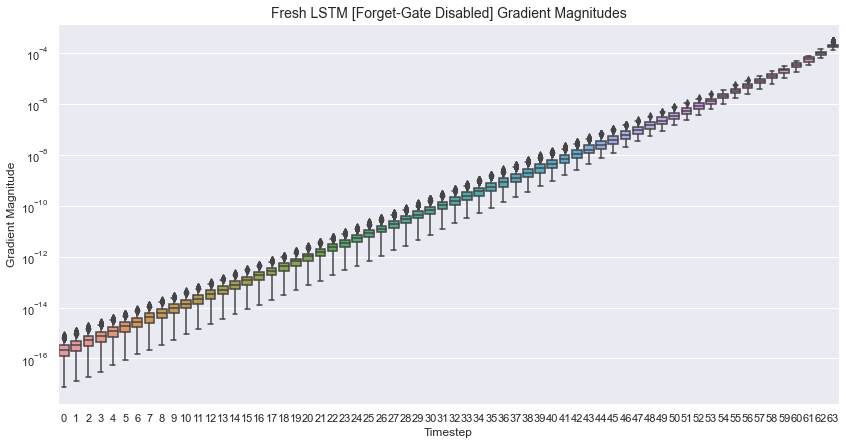

In [43]:
gradients_prepared_lstm_nf_fresh = pd.melt(lstm_grads_nf_fresh, value_vars=lstm_grads_nf_fresh.columns)
gradients_prepared_lstm_nf_fresh.columns = ('Timestep', 'Gradient Magnitude')

fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title('Fresh LSTM [Forget-Gate Disabled] Gradient Magnitudes', fontsize=14)
ax.set(yscale='log')

_ = sns.boxplot(x='Timestep', y='Gradient Magnitude', data=gradients_prepared_lstm_nf_fresh, ax=ax)

In [44]:
# The Gradients' ranges of the earlier timesteps is much larger the ranges of the latest timesteps, which is expected because
# the network visits these parts more often "As I understand" "in the first epoch" which when disabling the forget gate
# will give more weight to them in some cases.
# Also we can clearly see that the network was able to identify the importance of the last 2 time-steps in the sequence,
# which highlights the importance of these timesteps if we remedied the problem of the large variance caused by the disabled gate

<div class="alert alert-warning">
    <b>Exercise 3.3. [10 Points]</b>
    <ul>
        <li>Use the already trained <code>LSTM</code> instance from the beginning of this section for collecting its gradients w.r.t. the network input using the latch sequence training set.</li>
        <li>Visualize the collected gradients together with the gradients of the <i>freshly</i> created <code>LSTM</code> instance accordingly. What do you observe? Comment on your results.</li>
    </ul>
</div>

In [45]:
lstm_trained_nf_grads = collect_gradients(model=lstm_model_nf, loader=data_loader_train)

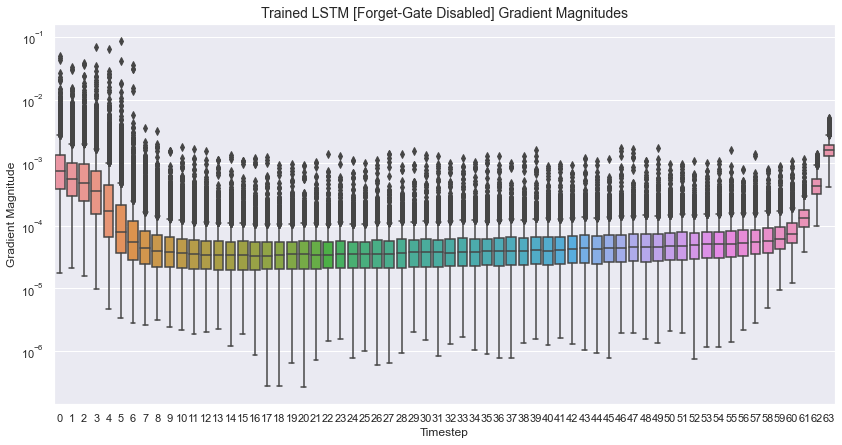

In [46]:
gradients_prepared_lstm_nf_trained = pd.melt(lstm_trained_nf_grads, value_vars=lstm_trained_nf_grads.columns)
gradients_prepared_lstm_nf_trained.columns = ('Timestep', 'Gradient Magnitude')

fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title('Trained LSTM [Forget-Gate Disabled] Gradient Magnitudes', fontsize=14)
ax.set(yscale='log')

_ = sns.boxplot(x='Timestep', y='Gradient Magnitude', data=gradients_prepared_lstm_nf_trained, ax=ax)

In [47]:
# We can Clearly See that the network was able to identify some sort of a trend in the data-sequence highlighing the last 20
# time-steps more than the early ones, but still the problem of keeping the early gradients range high that's caused by disabling
# the forget gate affects the general behavior of the network.

<div class="alert alert-warning">
    <b>Exercise 3.4. [10 Points]</b>
    <ul>
        <li>Train an <code>LSTM</code> network for $15$ epochs, print the training accuracy as well as the loss per epoch and report the final test set loss and accuracy. Use an initial forget gate bias of $1.0$. Do you expect the resulting performance?</li>
        <li>Use the newly trained <code>LSTM</code> instance for collecting its gradients w.r.t. the network input using the latch sequence training set.</li>
        <li>Visualize the collected gradients together with the gradients of the <i>freshly</i> created <code>LSTM</code> instance accordingly. What do you observe? Comment on your results.</li>
    </ul>
</div>

In [48]:
# CUDA Version!!
# hidden_size = 32, forget_gate = True
u4.set_seed(42)

target_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model_f = LSTM(input_size=data_latch.num_characters, output_size=data_latch.num_targets, hidden_size=32, forget_gate=True).to(target_device)
optimizer = torch.optim.Adam(lstm_model_f.parameters(), lr=1e-2)

print(lstm_model_f, end='\n\n')

num_epochs = 15
for epoch in range(num_epochs):
    
    u4.train_network(model=lstm_model_f, data_loader=data_loader_train, device=target_device, optimizer=optimizer)
    
    performance = u4.test_network(model=lstm_model_f, data_loader=data_loader_train, device=target_device)
    
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Loss: {performance[0]:.4f} / Accuracy: {performance[1]:.4f}')

performance = u4.test_network(model=lstm_model_f, data_loader=data_loader_test, device=target_device)
print(f'\nFinal loss: {performance[0]:.4f} / Final accuracy: {performance[1]:.4f}')

LSTM(
  (lstm1): LSTM(26, 32, batch_first=True)
  (fc1): Linear(in_features=32, out_features=25, bias=True)
)

Epoch: 01 / Loss: 0.0503 / Accuracy: 0.0465
Epoch: 02 / Loss: 0.0503 / Accuracy: 0.0423
Epoch: 03 / Loss: 0.0501 / Accuracy: 0.0514
Epoch: 04 / Loss: 0.0501 / Accuracy: 0.0573
Epoch: 05 / Loss: 0.0500 / Accuracy: 0.0615
Epoch: 06 / Loss: 0.0499 / Accuracy: 0.0635
Epoch: 07 / Loss: 0.0498 / Accuracy: 0.0703
Epoch: 08 / Loss: 0.0496 / Accuracy: 0.0674
Epoch: 09 / Loss: 0.0495 / Accuracy: 0.0778
Epoch: 10 / Loss: 0.0493 / Accuracy: 0.0785
Epoch: 11 / Loss: 0.0491 / Accuracy: 0.0827
Epoch: 12 / Loss: 0.0490 / Accuracy: 0.0765
Epoch: 13 / Loss: 0.0488 / Accuracy: 0.0846
Epoch: 14 / Loss: 0.0487 / Accuracy: 0.0866
Epoch: 15 / Loss: 0.0486 / Accuracy: 0.0898

Final loss: 0.0512 / Final accuracy: 0.0518


In [49]:
# CPU version!!
# hidden_size = 32, forget_gate = True
u4.set_seed(42)

target_device = torch.device('cpu')
lstm_model_f_cpu = LSTM(input_size=data_latch.num_characters, output_size=data_latch.num_targets, hidden_size=32, forget_gate=True).to(target_device)
optimizer = torch.optim.Adam(lstm_model_f_cpu.parameters(), lr=1e-2)

print(lstm_model_f_cpu, end='\n\n')

num_epochs = 15
for epoch in range(num_epochs):
    
    u4.train_network(model=lstm_model_f_cpu, data_loader=data_loader_train, device=target_device, optimizer=optimizer)
    
    performance = u4.test_network(model=lstm_model_f_cpu, data_loader=data_loader_train, device=target_device)
    
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Loss: {performance[0]:.4f} / Accuracy: {performance[1]:.4f}')

performance = u4.test_network(model=lstm_model_f_cpu, data_loader=data_loader_test, device=target_device)
print(f'\nFinal loss: {performance[0]:.4f} / Final accuracy: {performance[1]:.4f}')

LSTM(
  (lstm1): LSTM(26, 32, batch_first=True)
  (fc1): Linear(in_features=32, out_features=25, bias=True)
)

Epoch: 01 / Loss: 0.0503 / Accuracy: 0.0465
Epoch: 02 / Loss: 0.0503 / Accuracy: 0.0423
Epoch: 03 / Loss: 0.0501 / Accuracy: 0.0514
Epoch: 04 / Loss: 0.0501 / Accuracy: 0.0573
Epoch: 05 / Loss: 0.0500 / Accuracy: 0.0615
Epoch: 06 / Loss: 0.0499 / Accuracy: 0.0635
Epoch: 07 / Loss: 0.0498 / Accuracy: 0.0703
Epoch: 08 / Loss: 0.0496 / Accuracy: 0.0674
Epoch: 09 / Loss: 0.0495 / Accuracy: 0.0778
Epoch: 10 / Loss: 0.0493 / Accuracy: 0.0785
Epoch: 11 / Loss: 0.0491 / Accuracy: 0.0827
Epoch: 12 / Loss: 0.0490 / Accuracy: 0.0765
Epoch: 13 / Loss: 0.0488 / Accuracy: 0.0846
Epoch: 14 / Loss: 0.0487 / Accuracy: 0.0866
Epoch: 15 / Loss: 0.0486 / Accuracy: 0.0902

Final loss: 0.0512 / Final accuracy: 0.0527


In [50]:
# CUDA Version
# hidden_size = 64, forget_gate = True
u4.set_seed(42)

target_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model_f_2 = LSTM(input_size=data_latch.num_characters, output_size=data_latch.num_targets, hidden_size=64, forget_gate=True).to(target_device)
optimizer = torch.optim.Adam(lstm_model_f_2.parameters(), lr=1e-2)

print(lstm_model_f_2, end='\n\n')

num_epochs = 15
for epoch in range(num_epochs):
    
    u4.train_network(model=lstm_model_f_2, data_loader=data_loader_train, device=target_device, optimizer=optimizer)
    
    performance = u4.test_network(model=lstm_model_f_2, data_loader=data_loader_train, device=target_device)
    
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Loss: {performance[0]:.4f} / Accuracy: {performance[1]:.4f}')

performance = u4.test_network(model=lstm_model_f_2, data_loader=data_loader_test, device=target_device)
print(f'\nFinal loss: {performance[0]:.4f} / Final accuracy: {performance[1]:.4f}')

LSTM(
  (lstm1): LSTM(26, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
)

Epoch: 01 / Loss: 0.0505 / Accuracy: 0.0407
Epoch: 02 / Loss: 0.0503 / Accuracy: 0.0479
Epoch: 03 / Loss: 0.0503 / Accuracy: 0.0479
Epoch: 04 / Loss: 0.0502 / Accuracy: 0.0518
Epoch: 05 / Loss: 0.0500 / Accuracy: 0.0514
Epoch: 06 / Loss: 0.0499 / Accuracy: 0.0482
Epoch: 07 / Loss: 0.0498 / Accuracy: 0.0674
Epoch: 08 / Loss: 0.0496 / Accuracy: 0.0648
Epoch: 09 / Loss: 0.0493 / Accuracy: 0.0736
Epoch: 10 / Loss: 0.0493 / Accuracy: 0.0622
Epoch: 11 / Loss: 0.0490 / Accuracy: 0.0752
Epoch: 12 / Loss: 0.0487 / Accuracy: 0.0876
Epoch: 13 / Loss: 0.0483 / Accuracy: 0.0931
Epoch: 14 / Loss: 0.0482 / Accuracy: 0.0905
Epoch: 15 / Loss: 0.0478 / Accuracy: 0.1045

Final loss: 0.0516 / Final accuracy: 0.0420


In [51]:
# CPU Version
# hidden_size = 64, forget_gate = True
u4.set_seed(42)

target_device = torch.device('cpu')
lstm_model_f_2_cpu = LSTM(input_size=data_latch.num_characters, output_size=data_latch.num_targets, hidden_size=64, forget_gate=True).to(target_device)
optimizer = torch.optim.Adam(lstm_model_f_2_cpu.parameters(), lr=1e-2)

print(lstm_model_f_2_cpu, end='\n\n')

num_epochs = 15
for epoch in range(num_epochs):
    
    u4.train_network(model=lstm_model_f_2_cpu, data_loader=data_loader_train, device=target_device, optimizer=optimizer)
    
    performance = u4.test_network(model=lstm_model_f_2_cpu, data_loader=data_loader_train, device=target_device)
    
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Loss: {performance[0]:.4f} / Accuracy: {performance[1]:.4f}')

performance = u4.test_network(model=lstm_model_f_2_cpu, data_loader=data_loader_test, device=target_device)
print(f'\nFinal loss: {performance[0]:.4f} / Final accuracy: {performance[1]:.4f}')

LSTM(
  (lstm1): LSTM(26, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
)

Epoch: 01 / Loss: 0.0505 / Accuracy: 0.0407
Epoch: 02 / Loss: 0.0503 / Accuracy: 0.0479
Epoch: 03 / Loss: 0.0503 / Accuracy: 0.0479
Epoch: 04 / Loss: 0.0502 / Accuracy: 0.0518
Epoch: 05 / Loss: 0.0500 / Accuracy: 0.0514
Epoch: 06 / Loss: 0.0499 / Accuracy: 0.0482
Epoch: 07 / Loss: 0.0498 / Accuracy: 0.0674
Epoch: 08 / Loss: 0.0496 / Accuracy: 0.0648
Epoch: 09 / Loss: 0.0493 / Accuracy: 0.0736
Epoch: 10 / Loss: 0.0493 / Accuracy: 0.0622
Epoch: 11 / Loss: 0.0490 / Accuracy: 0.0752
Epoch: 12 / Loss: 0.0487 / Accuracy: 0.0872
Epoch: 13 / Loss: 0.0483 / Accuracy: 0.0931
Epoch: 14 / Loss: 0.0482 / Accuracy: 0.0905
Epoch: 15 / Loss: 0.0478 / Accuracy: 0.1045

Final loss: 0.0516 / Final accuracy: 0.0420


In [52]:
# Assuming the CPU is the correct intended Version!!
# We clearly See the expected results confirming the previous hypothesis that the forget gate caused some unexpected behavior in
# the netowrk because it increased the variance of the gradients which gave fake importance to unimportant time-steps "features"

In [48]:
# Assuming the CPU Model
lstm_f_trained_f_grads = collect_gradients(model=lstm_model_f_cpu, loader=data_loader_train)

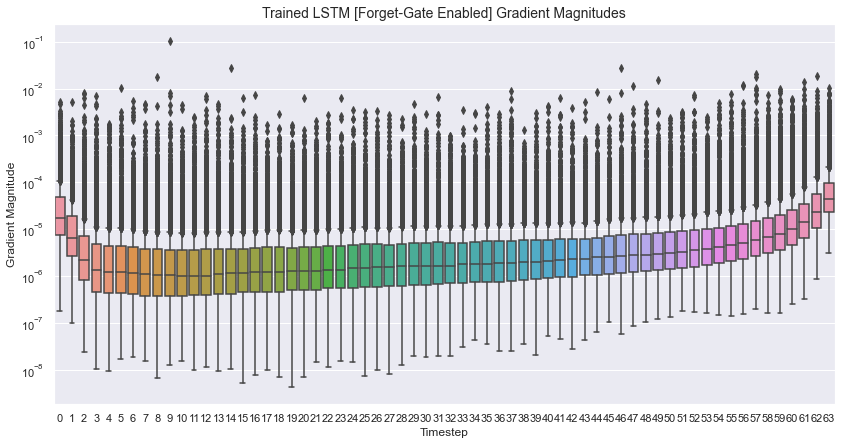

In [49]:
gradients_prepared_lstm_f_trained = pd.melt(lstm_f_trained_f_grads, value_vars=lstm_f_trained_f_grads.columns)
gradients_prepared_lstm_f_trained.columns = ('Timestep', 'Gradient Magnitude')

fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title('Trained LSTM [Forget-Gate Enabled] Gradient Magnitudes', fontsize=14)
ax.set(yscale='log')

_ = sns.boxplot(x='Timestep', y='Gradient Magnitude', data=gradients_prepared_lstm_f_trained, ax=ax)

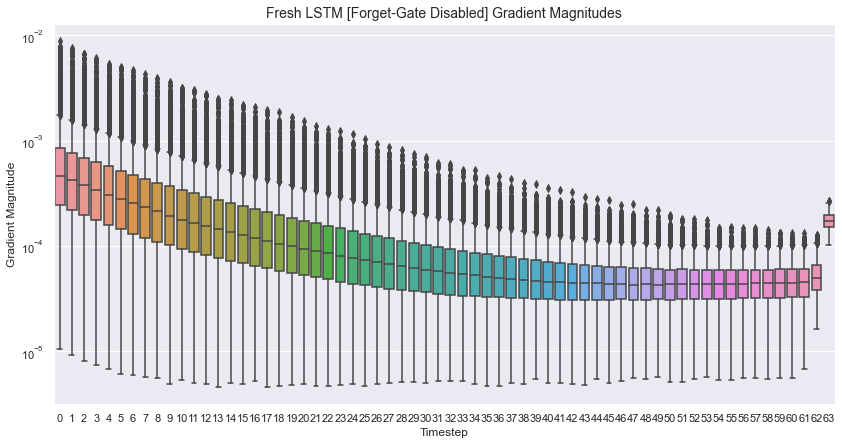

In [50]:
gradients_prepared_lstm_nf_fresh = pd.melt(lstm_grads_nf_fresh, value_vars=lstm_grads_nf_fresh.columns)
gradients_prepared_lstm_nf_fresh.columns = ('Timestep', 'Gradient Magnitude')

fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title('Fresh LSTM [Forget-Gate Disabled] Gradient Magnitudes', fontsize=14)
ax.set(yscale='log')

_ = sns.boxplot(x='Timestep', y='Gradient Magnitude', data=gradients_prepared_lstm_nf_fresh, ax=ax)

In [51]:
lstm_model_f_fresh = LSTM(input_size=data_latch.num_characters, output_size=data_latch.num_targets, hidden_size=32, forget_gate=True)
lstm_f_trained_f_fresh_grads = collect_gradients(model=lstm_model_f_fresh, loader=data_loader_train)

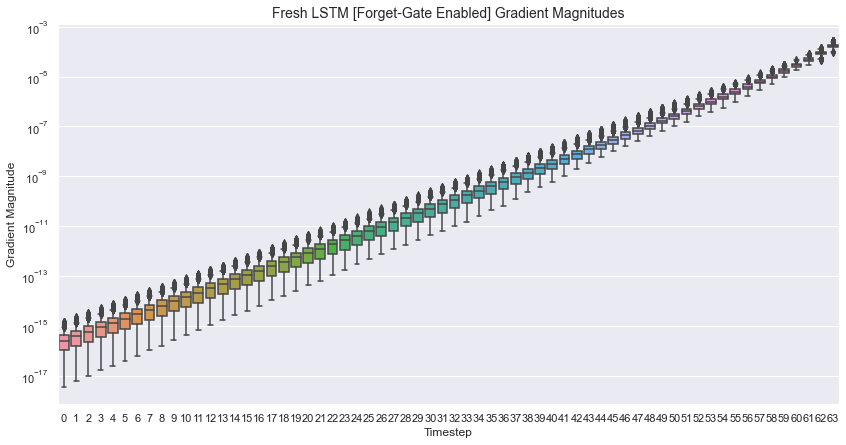

In [52]:
# Prepare collected gradients for plotting.
gradients_prepared_lstm_f_fresh = pd.melt(lstm_f_trained_f_fresh_grads, value_vars=lstm_f_trained_f_fresh_grads.columns)
gradients_prepared_lstm_f_fresh.columns = ('Timestep', 'Gradient Magnitude')

# Define plotting figure and corresponding attributes.
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title('Fresh LSTM [Forget-Gate Enabled] Gradient Magnitudes', fontsize=14)
ax.set(yscale='log')

# Plot pre-processed gradients.
_ = sns.boxplot(x='Timestep', y='Gradient Magnitude', data=gradients_prepared_lstm_f_fresh, ax=ax)

In [58]:
# Case 1
# Trained Forget Gate [Enabled]:
# We can Clearly see the balanced weights of the matrix without any numerical instabilities treating every time-step equally
# important

# Case 2
# Fresh Forget Gate [Disabled]:
# The Gradients' ranges of the earlier timesteps is much larger the ranges of the latest timesteps, which is expected because
# the network visits these parts more often "As I understand" "in the first epoch" which when disabling the forget gate
# will give more weight to them in some cases.

# Case 3
# Fresh Forget Gate [Enabled]:
# The Gradients in the earliest time-steps during the first epoch is almost totally "forgotten" during the first epoch, since
# everytime they are visited they are getting lower in magnitude "during the first epoch".